# Student Performance Analysis and Predictive Modeling

## Project Statement
This project focuses on analyzing students' academic performance based on  maths exam scores and demographic information. Using a combination of **exploratory data analysis (EDA)**, **feature engineering**, **statistical tests**, and **machine learning models**, the aim is to understand the key factors influencing students' performance and build predictive models to estimate future maths exam outcomes. The project emphasizes **model explainability** using SHAP values to provide transparent insights into feature contributions.

## Objectives
1. **Exploratory Data Analysis (EDA)**
   - Perform univariate and bivariate analysis for numerical and categorical features.
   - Visualize distributions, relationships, and potential outliers.

2. **Data Preprocessing**
   - encode categorical variables using one-hot encoding.
   - Transform target variables using Yeo-Johnson to stabilize variance.

3. **Statistical Analysis**
   - Perform correlation analysis, Chi-Square tests, and ANOVA to identify relationships and feature importance.

4. **Predictive Modeling**
   - Fit and evaluate various regression models, including:
     - **Linear Regression** (with sample weights)
     - **Regularized Linear Models:** Lasso, Ridge, ElasticNet (with cross-validation)
     - **Tree-based Models:** XGBoost, LightGBM
   - Optimize models using hyperparameter tuning and cross-validation to reduce overfitting.

5. **Model Evaluation**
   - Evaluate models using metrics such as MAE, RMSE, and R².
   - Perform residual analysis to check assumptions and model robustness.

6. **Model Explainability**
   - Use **SHAP** to interpret model predictions.
   - Generate summary, beeswarm, and dependence plots to demonstrate feature impact on predictions.

7. **Insights and Recommendations**
   - Identify the most influential factors affecting student performance.
   - Provide actionable insights to stakeholders such as educators and school administrators.

## Tools & Libraries
- Python (pandas, numpy, matplotlib, seaborn, scikit-learn, statsmodels)
- XGBoost, LightGBM, SHAP
- Optuna for hyperparameter optimization



In [2]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Regression models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import xgboost as xgb

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical analysis
from scipy.stats import skew, kurtosis, jarque_bera, chi2_contingency, f_oneway
import statsmodels.api as sm
from itertools import combinations

# Model explainability
import shap

# Hyperparameter optimization
import optuna

In [3]:
#Reading the Dataset into a Pandas DataFrame
df = pd.read_csv(r"C:\Users\HP\Downloads\StudentsPerformance.csv")

#### Data Understanding

In [5]:
#The shape of the dataset
df.shape

(1000, 8)

The Dataset contains 1000 observations across 8 columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


The dataset has no missing values. It contains five categorical variables and two continuous predictor variables, in addition to the target variable, math score, which we aim to predict.

In [9]:
#Descriptive summary of the dataset
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [10]:
#viewing the first few rows of the the datset

df.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


### Exploratory Data Analysis


#### Target Variable Analysis

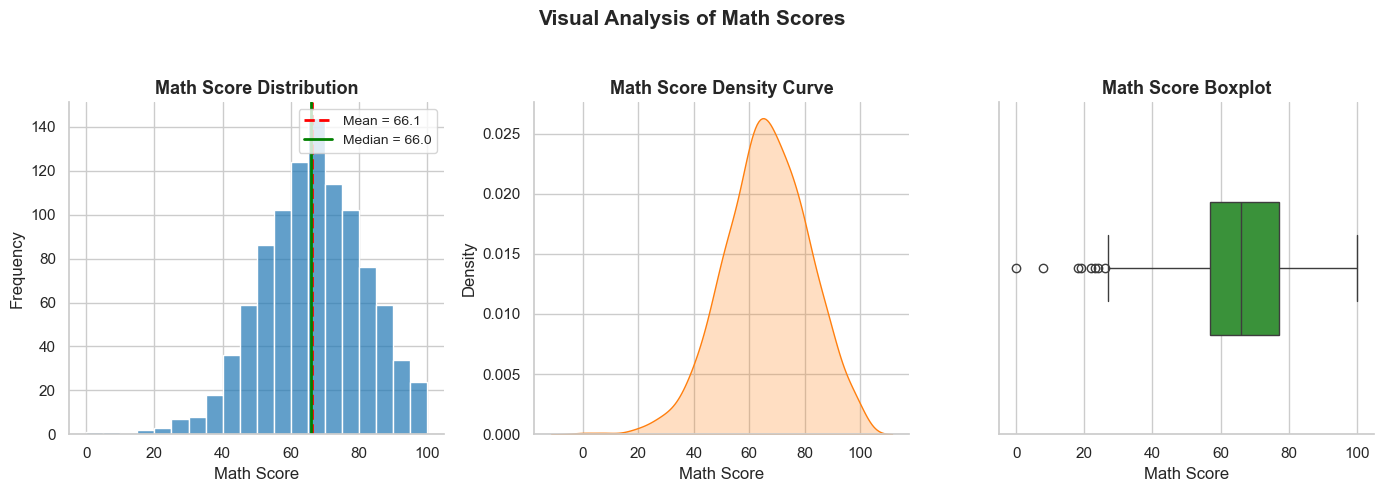

In [13]:

# Style
sns.set(style="whitegrid", palette="husl")

# Compute statistics
mean_val = df['math score'].mean()
median_val = df['math score'].median()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# ---  Histogram ---
sns.histplot(df['math score'], bins=20, color='#1f77b4', alpha=0.7, ax=axes[0])
axes[0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.1f}')
axes[0].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median = {median_val:.1f}')
axes[0].set_title('Math Score Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Math Score')
axes[0].set_ylabel('Frequency')
axes[0].legend(fontsize=10, loc='upper right', frameon=True)

# ---  KDE Plot ---
sns.kdeplot(data=df, x='math score', fill=True, color='#ff7f0e', ax=axes[1])
axes[1].set_title('Math Score Density Curve', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Math Score')
axes[1].set_ylabel('Density')

# ---  Boxplot ---
sns.boxplot(data=df, x='math score', color='#2ca02c', width=0.4, ax=axes[2])
axes[2].set_title('Math Score Boxplot', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Math Score')
axes[2].set_ylabel('')

# Tidy up layout
plt.suptitle('Visual Analysis of Math Scores', fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()



#### Basic Explanation of Math Score Visualizations

Left Graph: Score Distribution
- Shows how many students got each score
- The **bell curve** shows most students scored near the middle
- **Mean (66.1)** = average score
- **Median (66.0)** = middle score (half above, half below)
- Most scores cluster between 50-80

Right Graph: Score Boxplot
- Shows the spread of scores in a simple way
- The **box** shows the middle 50% of scores (between ~55-77)
- The **line in the box** = median score (66)
- The **whiskers** show the overall range of typical scores
- **Dots** outside = unusual scores (very high or very low)

 Simple Summary
Most students scored around 66 in math, with scores typically ranging from about 40 to 85.

In [15]:

# ---  Statistical Normality Metrics ---
data_skewness = skew(df['math score'])
data_kurtosis = kurtosis(df['math score'])
jb_stat, jb_p = jarque_bera(df['math score'])   # ✅ fixed unpacking


print(" Normality Test Summary")
print("-" * 35)
print(f"Skewness       : {data_skewness:.4f}")
print(f"Kurtosis       : {data_kurtosis:.4f}")
print(f"Jarque–Bera    : {jb_stat:.4f}")
print(f"P-value         : {jb_p:.4f}")

# Interpret the p-value
if jb_p < 0.05:
    print("\n The data significantly deviates from a normal distribution (p < 0.05).")
else:
    print("\n The data does not significantly deviate from a normal distribution (p ≥ 0.05).")

 Normality Test Summary
-----------------------------------
Skewness       : -0.2785
Kurtosis       : 0.2676
Jarque–Bera    : 15.9123
P-value         : 0.0004

 The data significantly deviates from a normal distribution (p < 0.05).


### Univariate Analysis - Continous Features and categorical Features

In [17]:
num_col = df.select_dtypes(include = ['float','int']).drop('math score',axis = 1).columns.tolist()

In [18]:
num_col

['reading score', 'writing score']

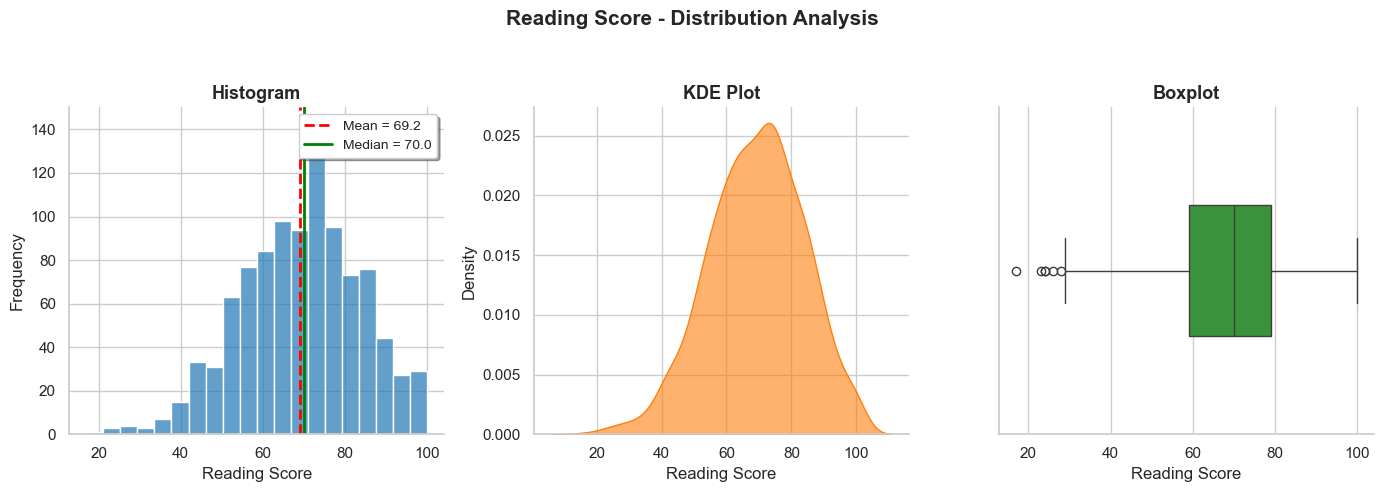

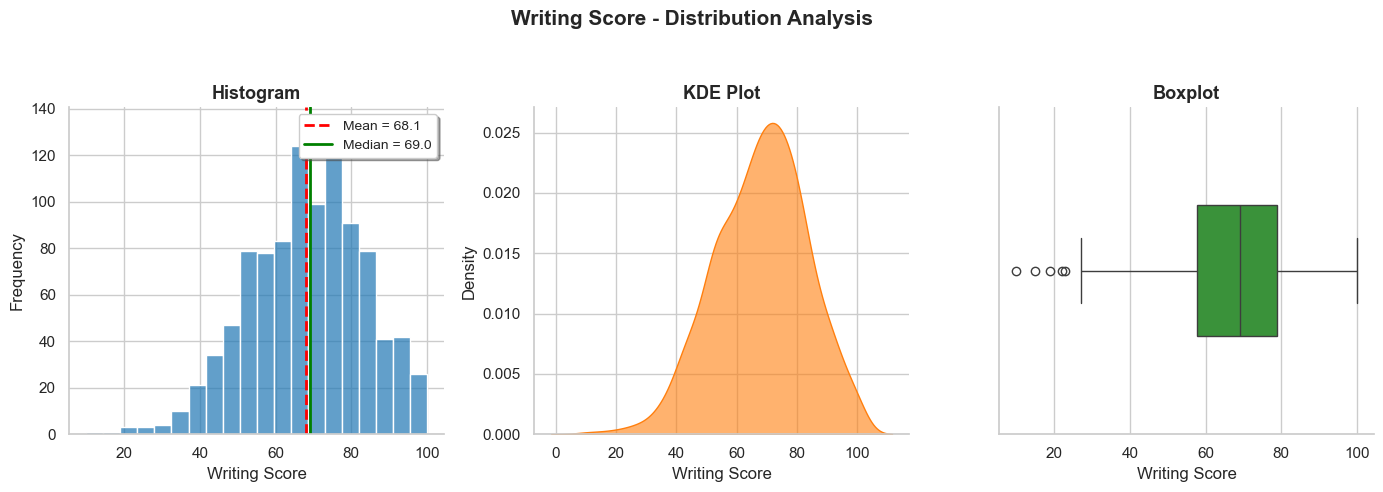

In [19]:
# Seaborn style
sns.set(style="whitegrid", palette="muted")

# Loop through each numerical column
for col in num_col:
    # Compute summary stats
    mean_val = df[col].mean()
    median_val = df[col].median()

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    fig.suptitle(f'{col.title()} - Distribution Analysis', fontsize=15, fontweight='bold')

    # ---  Histogram ---
    sns.histplot(df[col], bins=20, kde=False, color='#1f77b4', alpha=0.7, ax=axes[0])
    axes[0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.1f}')
    axes[0].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median = {median_val:.1f}')
    axes[0].set_title('Histogram', fontsize=13, fontweight='bold')
    axes[0].set_xlabel(col.title())
    axes[0].set_ylabel('Frequency')
    axes[0].legend(fontsize=10, loc='upper right', frameon=True, shadow=True)

    # ---  KDE Plot ---
    sns.kdeplot(data=df, x=col, fill=True, color='#ff7f0e', alpha=0.6, ax=axes[1])
    axes[1].set_title('KDE Plot', fontsize=13, fontweight='bold')
    axes[1].set_xlabel(col.title())
    axes[1].set_ylabel('Density')

    # ---  Boxplot ---
    sns.boxplot(data=df, x=col, color='#2ca02c', width=0.4, ax=axes[2])
    axes[2].set_title('Boxplot', fontsize=13, fontweight='bold')
    axes[2].set_xlabel(col.title())
    axes[2].set_ylabel('')

    # Clean layout
    sns.despine()
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

In [20]:
#Analysis for continous variable

cat_cols = df.select_dtypes(include = ['object']).columns.tolist()

In [21]:
cat_cols

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

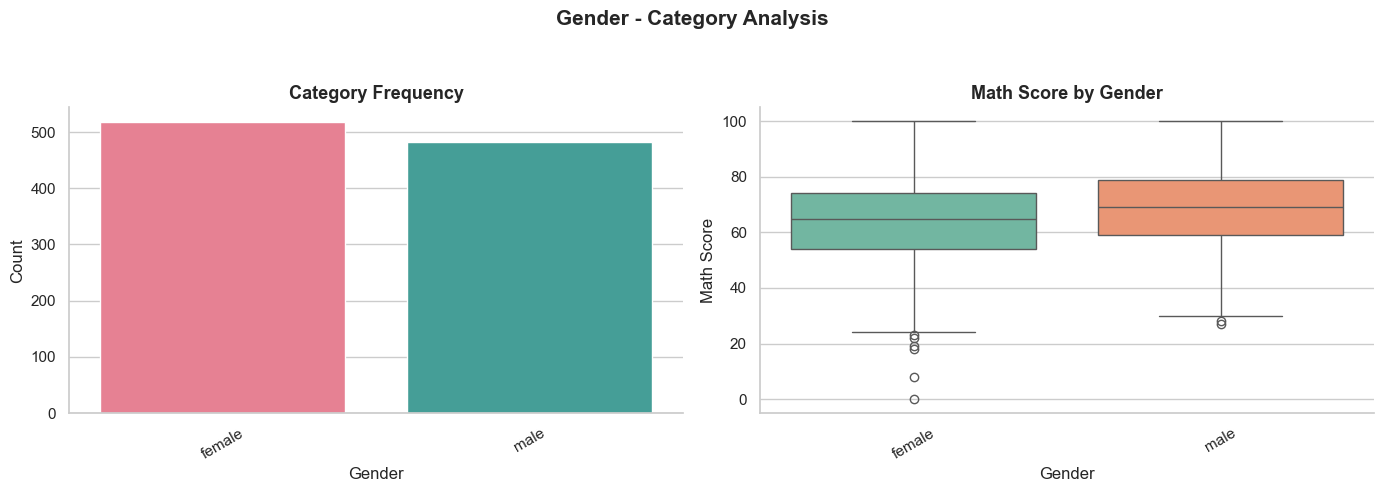

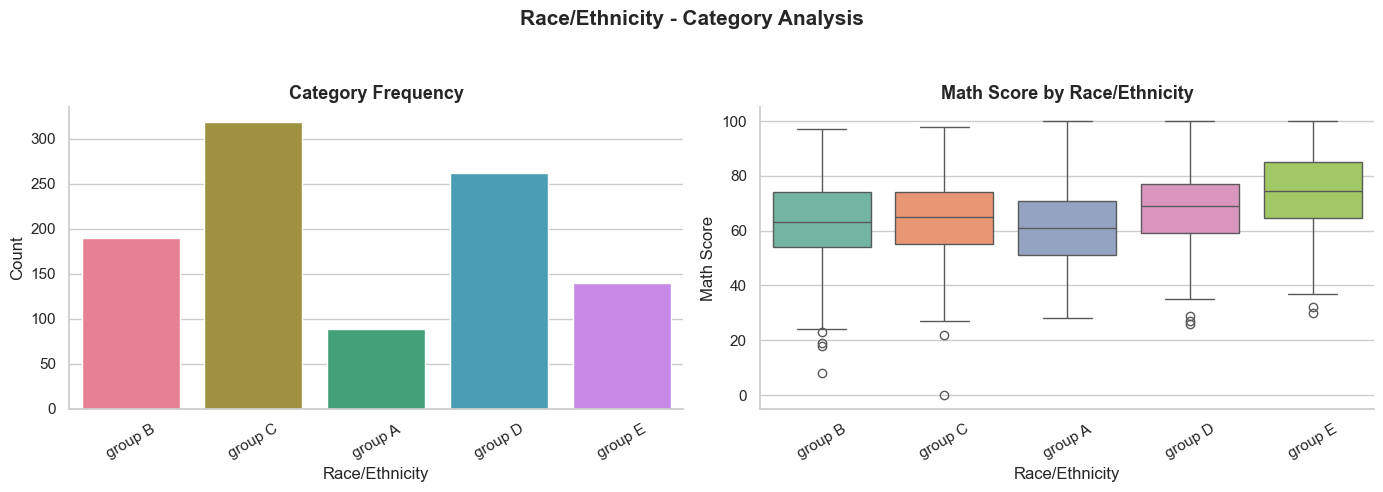

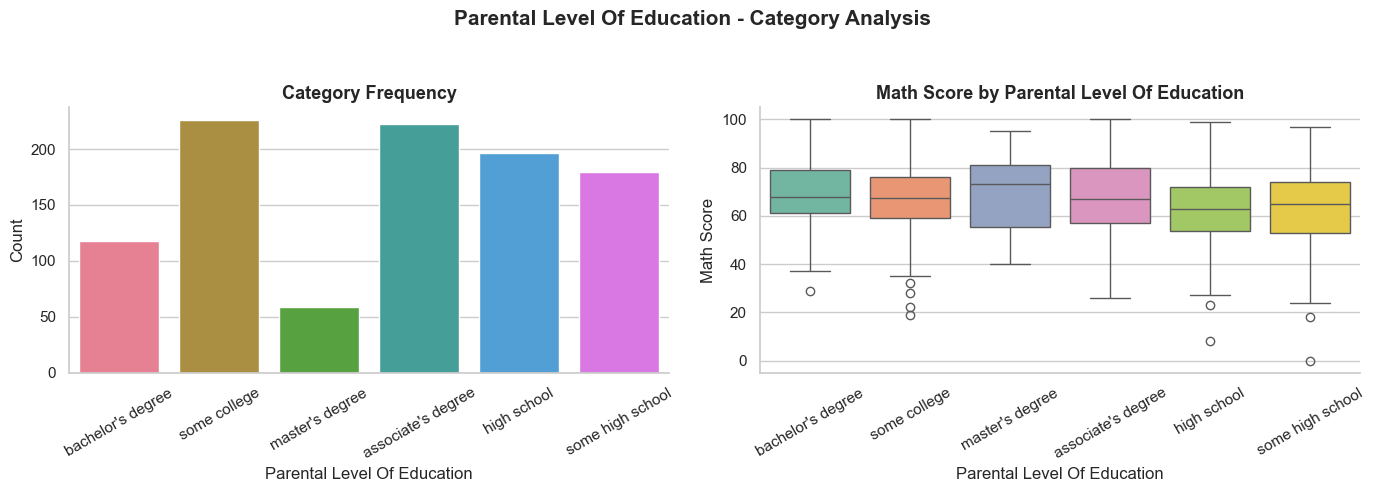

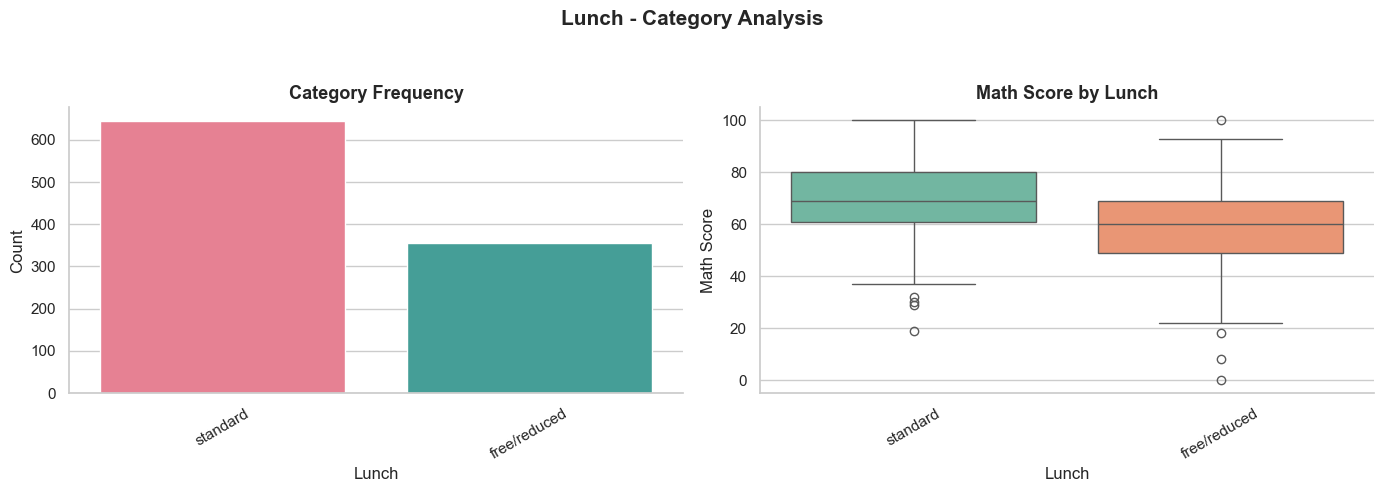

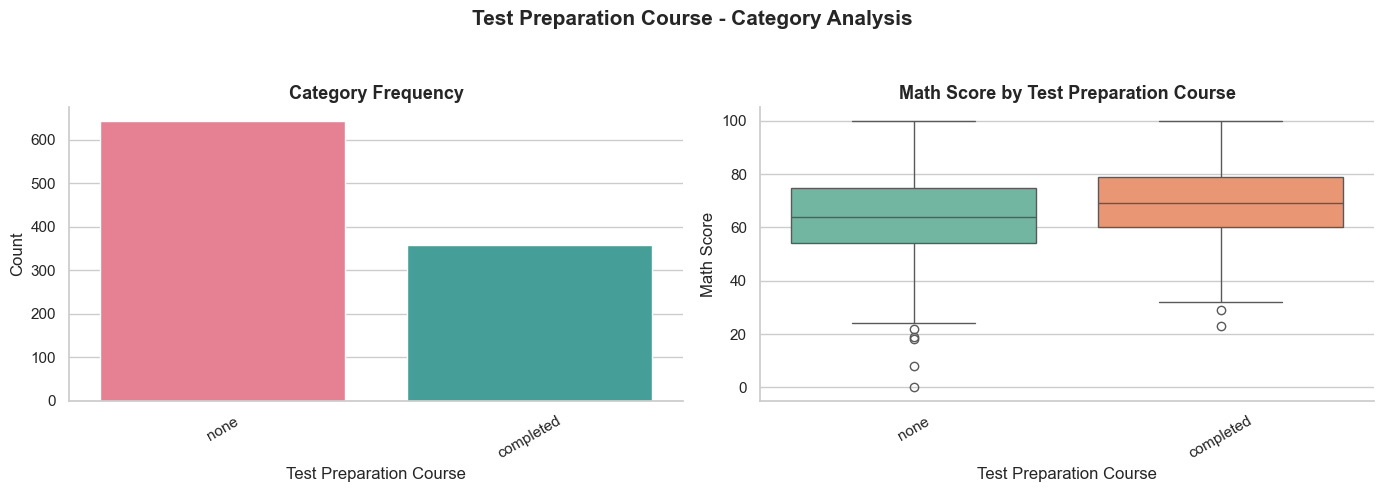

In [22]:


# Target numeric variable (you can change this)
target = 'math score'

# Set style
sns.set(style="whitegrid", palette="husl")

for col in cat_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{col.title()} - Category Analysis', fontsize=15, fontweight='bold')

    # ---  Countplot ---
    sns.countplot(data=df, x=col, palette="husl", ax=axes[0])
    axes[0].set_title('Category Frequency', fontsize=13, fontweight='bold')
    axes[0].set_xlabel(col.title())
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=30)

    # ---  Boxplot (Category vs Numeric Variable) ---
    sns.boxplot(data=df, x=col, y=target, palette="Set2", ax=axes[1])
    axes[1].set_title(f'{target.title()} by {col.title()}', fontsize=13, fontweight='bold')
    axes[1].set_xlabel(col.title())
    axes[1].set_ylabel(target.title())
    axes[1].tick_params(axis='x', rotation=30)

    # Clean up layout
    sns.despine()
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


### Bivariate Analysis - Numerical Features with Respecct to the Target

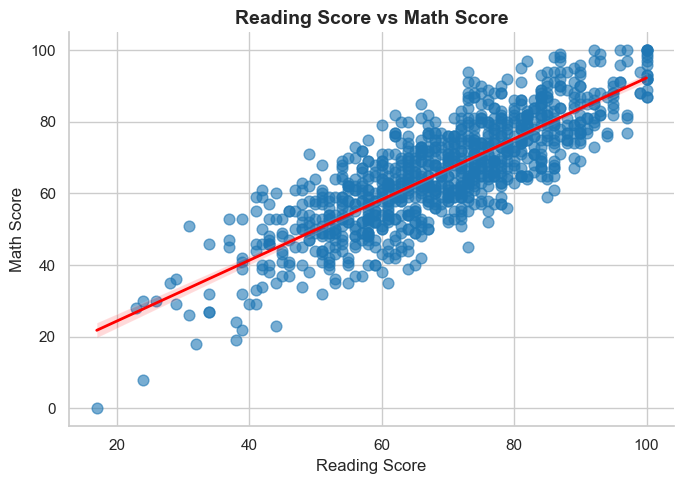

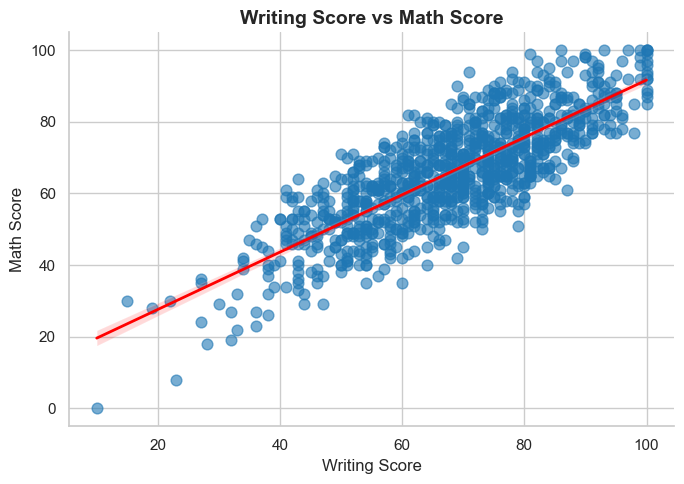

In [24]:

# --- Scatterplots with Regression Lines ---
for col in num_col:
    if col != target:
        plt.figure(figsize=(7, 5))
        sns.regplot(
            data=df, 
            x=col, 
            y=target, 
            scatter_kws={'alpha': 0.6, 's': 60, 'color': '#1f77b4'}, 
            line_kws={'color': 'red', 'lw': 2}
        )
        plt.title(f'{col.title()} vs {target.title()}', fontsize=14, fontweight='bold')
        plt.xlabel(col.title(), fontsize=12)
        plt.ylabel(target.title(), fontsize=12)
        sns.despine()
        plt.tight_layout()
        plt.show()



Both the Reading Score and Writing Score are strongly correlated with the Math Score.

###  Multi Variate Analysis with respect to the Target


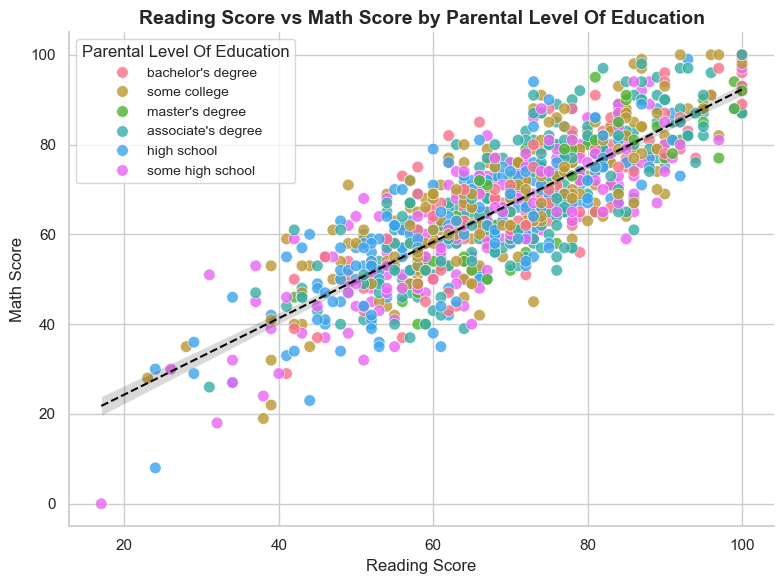

In [27]:

# Multi Variate Analysis
# Choose variables
cont_var = 'reading score'          # continuous variable
cat_var = 'parental level of education'                  # categorical variable
target = 'math score'               # target variable

sns.set(style="whitegrid", palette="husl")

# --- 1️⃣ Scatterplot (Continuous vs Target, Hue = Categorical Variable) ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x=cont_var,
    y=target,
    hue=cat_var,
    palette='husl',
    s=70,
    alpha=0.8,
    edgecolor='white',
    linewidth=0.5
)
sns.regplot(
    data=df,
    x=cont_var,
    y=target,
    scatter=False,
    color='black',
    line_kws={'lw': 1.5, 'ls': '--'}
)
plt.title(f'{cont_var.title()} vs {target.title()} by {cat_var.title()}', fontsize=14, fontweight='bold')
plt.xlabel(cont_var.title())
plt.ylabel(target.title())
plt.legend(title=cat_var.title(), fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()




Children whose parents’ highest level of education is high school tend to have lower scores.

#### Multi-Collinearity Test
Purpose of Testing for Multicollinearity:

* To identify highly correlated predictors before fitting a regression model.

* To decide which variables to keep, drop, or combine for a more stable and interpretable model.

#### Pearson Correlation between Numerical Features

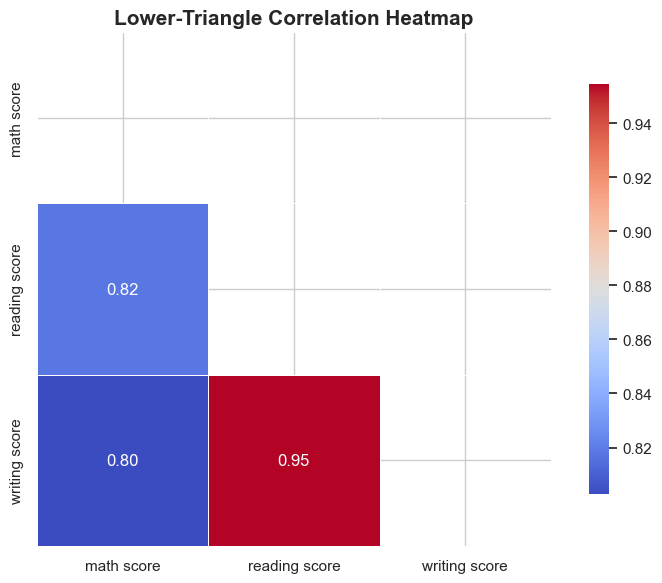

In [31]:
# --- Beautiful Lower-Triangle Correlation Heatmap ---
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only = True)

mask = np.triu(np.ones_like(corr, dtype=bool))  # upper triangle mask
sns.heatmap(
    corr, 
    mask=mask,
    cmap='coolwarm', 
    annot=True, 
    fmt='.2f', 
    linewidths=0.5, 
    cbar_kws={'shrink': 0.8},
    square=True
)
plt.title('Lower-Triangle Correlation Heatmap', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


#### Chi Sqaure Test for Collinearity between Categorical Features

In [33]:

from itertools import combinations
from scipy.stats import chi2_contingency


# --- Function for Chi-Square test ---
def chi_square_collinearity(df, cat_col):
    results = []

    print(" Chi-Square Test for Categorical Collinearity")
    print("-" * 60)

    # Loop through all unique pairs of categorical variables
    for col1, col2 in combinations(cat_col, 2):
        contingency_table = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, _ = chi2_contingency(contingency_table)

        results.append({
            'Variable 1': col1,
            'Variable 2': col2,
            'Chi2 Stat': round(chi2, 3),
            'p-value': round(p, 4),
            'Significant (p < 0.05)': 'Yes' if p < 0.05 else 'No'
        })

        # Print clean result
        print(f"{col1} ↔ {col2}")
        print(f"  Chi2 = {chi2:.3f} | p = {p:.4f} | {' Dependent' if p < 0.05 else ' Independent'}\n")

    # Return summary as a DataFrame
    return pd.DataFrame(results)

# --- Run the test ---
chi_results = chi_square_collinearity(df, cat_cols)

# Display summary table
chi_results


 Chi-Square Test for Categorical Collinearity
------------------------------------------------------------
gender ↔ race/ethnicity
  Chi2 = 9.027 | p = 0.0604 |  Independent

gender ↔ parental level of education
  Chi2 = 3.385 | p = 0.6409 |  Independent

gender ↔ lunch
  Chi2 = 0.372 | p = 0.5421 |  Independent

gender ↔ test preparation course
  Chi2 = 0.016 | p = 0.9008 |  Independent

race/ethnicity ↔ parental level of education
  Chi2 = 29.459 | p = 0.0791 |  Independent

race/ethnicity ↔ lunch
  Chi2 = 3.442 | p = 0.4867 |  Independent

race/ethnicity ↔ test preparation course
  Chi2 = 5.488 | p = 0.2408 |  Independent

parental level of education ↔ lunch
  Chi2 = 1.111 | p = 0.9531 |  Independent

parental level of education ↔ test preparation course
  Chi2 = 9.544 | p = 0.0892 |  Independent

lunch ↔ test preparation course
  Chi2 = 0.221 | p = 0.6383 |  Independent



,Variable 1,Variable 2,Chi2 Stat,p-value,Significant (p < 0.05)
0,gender,race/ethnicity,9.027,0.0604,No
1,gender,parental level of education,3.385,0.6409,No
2,gender,lunch,0.372,0.5421,No
3,gender,test preparation course,0.016,0.9008,No
4,race/ethnicity,parental level of education,29.459,0.0791,No
5,race/ethnicity,lunch,3.442,0.4867,No
6,race/ethnicity,test preparation course,5.488,0.2408,No
7,parental level of education,lunch,1.111,0.9531,No
8,parental level of education,test preparation course,9.544,0.0892,No
9,lunch,test preparation course,0.221,0.6383,No


### ANOVA Test

We used the **ANOVA (Analysis of Variance) test** to evaluate the relationship between numerical predictors and the target variable. Specifically, it helps us:

- Identify which of the **highly correlated features** contributes less to explaining the target.
- Detect the **weaker predictors** among correlated variables, so we can consider dropping them.
- Improve model stability and reduce redundancy in the feature set.

In essence, ANOVA guides **feature selection** when multicollinearity exists among predictors.


In [35]:

# --- Function to perform ANOVA ---
def anova_test(df, num_cols, target):
    results = []
    print(" ANOVA F-Test for Numerical Variables vs Target")
    print("-" * 60)

    for col in num_col:
        if col != target:
            # Group data based on target quantiles (to mimic categorical groups)
            df['target_group'] = pd.qcut(df[target], q=4, duplicates='drop')

            # Get list of groups for ANOVA
            groups = [df[df['target_group'] == g][col] for g in df['target_group'].unique()]

            # Perform ANOVA test
            f_stat, p_val = f_oneway(*groups)

            results.append({
                'Feature': col,
                'F-Statistic': round(f_stat, 4),
                'p-value': round(p_val, 4),
                'Significant (p < 0.05)': 'Yes' if p_val < 0.05 else 'No'
            })

            print(f"{col} → F = {f_stat:.4f} | p = {p_val:.4f} | {'Significant' if p_val < 0.05 else ' Weak'}")

    # Drop temporary column and return results
    df.drop(columns=['target_group'], inplace=True, errors='ignore')
    return pd.DataFrame(results)

# --- Run ANOVA ---
anova_results = anova_test(df, num_col, target)

# Display summary table
anova_results


 ANOVA F-Test for Numerical Variables vs Target
------------------------------------------------------------
reading score → F = 447.0309 | p = 0.0000 | Significant
writing score → F = 397.2975 | p = 0.0000 | Significant


,Feature,F-Statistic,p-value,Significant (p < 0.05)
0,reading score,447.0309,0.0,Yes
1,writing score,397.2975,0.0,Yes



Despite the high collinearity between certain numerical features, both remain important predictors for our model with a very high F statistic.


### Data Preprocessing

In [38]:
X = df.drop('math score',axis = 1)
y = df['math score']

In [39]:
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=True)

In [40]:
#one hot encoding
ohe = ColumnTransformer([
    ('num_col','passthrough',num_col),
     ('cat_col',OneHotEncoder(drop = 'first',sparse_output = False),cat_cols)
])
X_train_encoded_df = pd.DataFrame(ohe.fit_transform(X_train),index = X_train.index,columns = ohe.get_feature_names_out())
X_test_encoded_df = pd.DataFrame(ohe.transform(X_test),index = X_test.index,columns = ohe.get_feature_names_out())


In [41]:
X_train_encoded_df

,num_col__reading score,num_col__writing score,cat_col__gender_male,cat_col__race/ethnicity_group B,cat_col__race/ethnicity_group C,cat_col__race/ethnicity_group D,cat_col__race/ethnicity_group E,cat_col__parental level of education_bachelor's degree,cat_col__parental level of education_high school,cat_col__parental level of education_master's degree,cat_col__parental level of education_some college,cat_col__parental level of education_some high school,cat_col__lunch_standard,cat_col__test preparation course_none
269,76.0,70.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
776,72.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
509,92.0,87.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
784,81.0,79.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
477,68.0,72.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,79.0,79.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
251,83.0,83.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
729,39.0,37.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
705,72.0,65.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
#Power Transforming the y_train
# Initialize the transformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)  # standardize=True scales to mean=0, std=1

# Fit on y_train and transform
y_train_pt = pt.fit_transform(y_train.values.reshape(-1, 1))

# Transform y_test using the same transformer
y_test_pt = pt.transform(y_test.values.reshape(-1, 1))


In [43]:
sample_weights = y_train / y_train.mean()


In [44]:
# 1. Create the model instance
linear_regression_model = LinearRegression()

# 2. Fit the model with sample weights
linear_regression_model.fit(X_train_encoded_df, y_train_pt, sample_weight=sample_weights)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Model Evaluation

In [46]:


# ---  Predict using the model ---
y_train_pred_pt = linear_regression_model.predict(X_train_encoded_df)
y_test_pred_pt = linear_regression_model.predict(X_test_encoded_df)

# ---  Inverse Yeo-Johnson transform to original scale ---
y_train_pred = pt.inverse_transform(y_train_pred_pt.reshape(-1, 1)).ravel()
y_test_pred = pt.inverse_transform(y_test_pred_pt.reshape(-1, 1)).ravel()

# --- Evaluate metrics ---
def regression_metrics(y_true, y_pred, label="Data"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f" {label} Metrics")
    print("-"*30)
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    print("\n")

# --- Print metrics for train and test ---
regression_metrics(y_train, y_train_pred, label="Train")
regression_metrics(y_test, y_test_pred, label="Test")


 Train Metrics
------------------------------
MAE : 4.4290
RMSE: 6.0249
R2  : 0.8404


 Test Metrics
------------------------------
MAE : 4.2618
RMSE: 5.5599
R2  : 0.8684




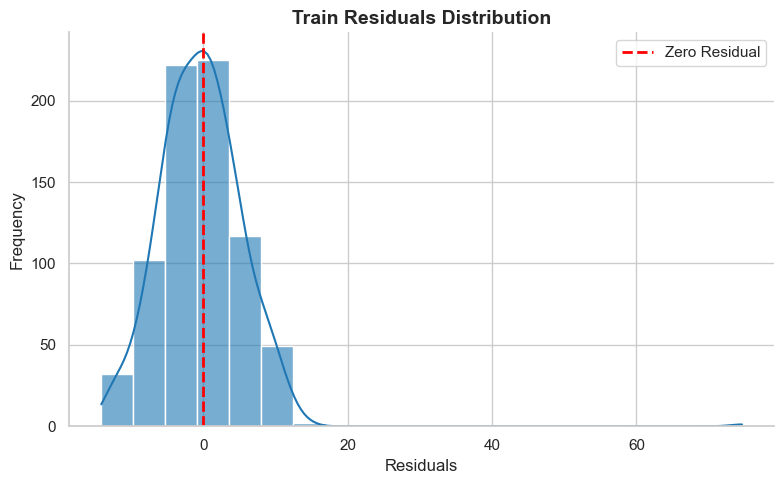

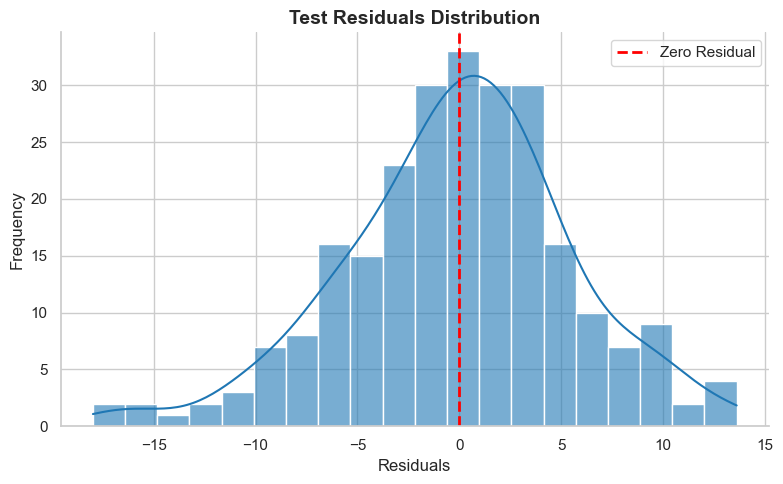

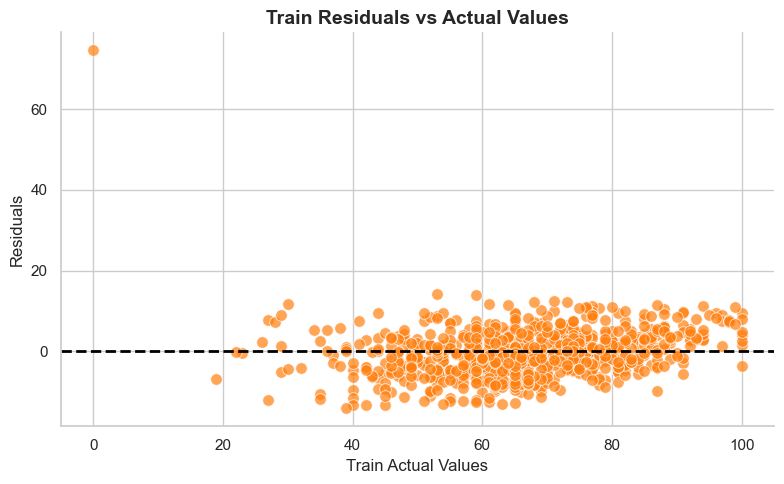

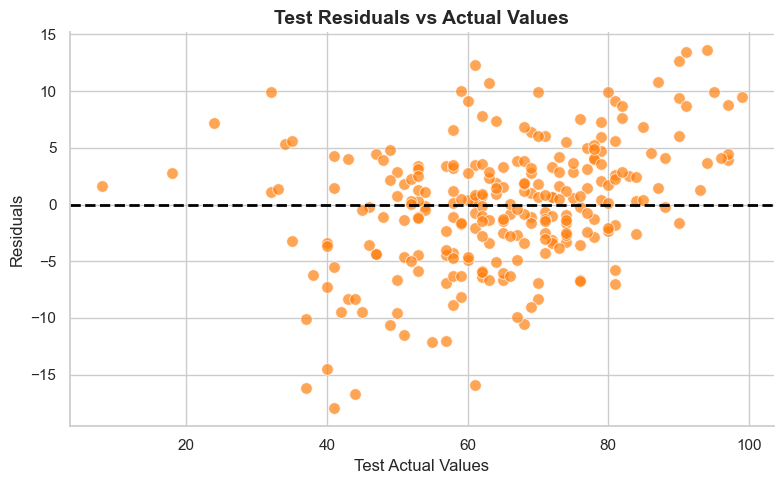

In [47]:


# --- Compute residuals ---
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred


# --- Residual Distribution: Histogram + KDE ---
for residuals, split in zip([train_residuals, test_residuals], ["Train", "Test"]):
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, color="#1f77b4", alpha=0.6, bins=20)
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    plt.title(f'{split} Residuals Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- Residuals vs Actual Values Scatter Plot ---
for y_true, residuals, split in zip([y_train, y_test], [train_residuals, test_residuals], ["Train", "Test"]):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_true, y=residuals, color="#ff7f0e", alpha=0.7, edgecolor='white', s=70)
    plt.axhline(0, color='black', linestyle='--', linewidth=2)
    plt.title(f'{split} Residuals vs Actual Values', fontsize=14, fontweight='bold')
    plt.xlabel(f'{split} Actual Values')
    plt.ylabel('Residuals')
    sns.despine()
    plt.tight_layout()
    plt.show()


The residuals of both the training and test sets show an approximately normal distribution, which satisfies an important assumption of linear regression.  

The training residuals appear perfectly homoscedastic, whereas the test residuals exhibit some heteroscedasticity. With appropriate adjustments, this heteroscedasticity can potentially be reduced.


#### Xgboost

In [50]:

# ---  Initialize the XGBoost Regressor ---
xgb_model = xgb.XGBRegressor()

# --- Fit on training data ---
xgb_model.fit(X_train_encoded_df, y_train_pt)  # fit on Yeo-Johnson transformed target

# --- Predict ---
y_train_pred_pt = xgb_model.predict(X_train_encoded_df)
y_test_pred_pt = xgb_model.predict(X_test_encoded_df)

# --- Inverse Yeo-Johnson transform to original scale ---
y_train_pred = pt.inverse_transform(y_train_pred_pt.reshape(-1, 1)).ravel()
y_test_pred = pt.inverse_transform(y_test_pred_pt.reshape(-1, 1)).ravel()

# --- Evaluate metrics ---
def regression_metrics(y_true, y_pred, label="Data"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f" {label} Metrics")
    print("-"*30)
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    print("\n")

# --- Print metrics for train and test ---
regression_metrics(y_train, y_train_pred, label="Train")
regression_metrics(y_test, y_test_pred, label="Test")


 Train Metrics
------------------------------
MAE : 0.6340
RMSE: 0.9830
R2  : 0.9958


 Test Metrics
------------------------------
MAE : 5.6481
RMSE: 6.9910
R2  : 0.7919




#### Hyperparameter Tuning on Xgboost

In [52]:

# --- Objective function for Optuna ---
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**params,early_stopping_rounds=50)
    model.fit(X_train_encoded_df, y_train_pt,
              eval_set=[(X_test_encoded_df, y_test_pt)],
              verbose=False)

    # Predict on test set
    y_pred_pt = model.predict(X_test_encoded_df)
    
    # Inverse Yeo-Johnson
    y_pred = pt.inverse_transform(y_pred_pt.reshape(-1, 1)).ravel()

    # Return RMSE as objective to minimize
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# --- Create Optuna study ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Best hyperparameters ---
print("Best hyperparameters:", study.best_params)

# --- Fit XGBoost with best hyperparameters ---
best_params = study.best_params
best_xgb = xgb.XGBRegressor(**best_params)
best_xgb.fit(X_train_encoded_df, y_train_pt)

# --- Predict and inverse Yeo-Johnson ---
y_train_pred_pt = best_xgb.predict(X_train_encoded_df)
y_test_pred_pt = best_xgb.predict(X_test_encoded_df)

y_train_pred = pt.inverse_transform(y_train_pred_pt.reshape(-1, 1)).ravel()
y_test_pred = pt.inverse_transform(y_test_pred_pt.reshape(-1, 1)).ravel()

# --- Evaluate metrics ---
def regression_metrics(y_true, y_pred, label="Data"):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f" {label} Metrics")
    print("-"*30)
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    print("\n")

regression_metrics(y_train, y_train_pred, label="Train")
regression_metrics(y_test, y_test_pred, label="Test")


[I 2025-11-12 13:20:05,387] A new study created in memory with name: no-name-26fe448e-938e-4d32-b967-87c6cab67c60


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-12 13:20:05,758] Trial 0 finished with value: 6.849545607148992 and parameters: {'n_estimators': 184, 'max_depth': 10, 'learning_rate': 0.05952660832460338, 'subsample': 0.8828089521103555, 'colsample_bytree': 0.9624198326055616, 'min_child_weight': 6, 'gamma': 2.959843511921532, 'reg_alpha': 2.8327811120816984, 'reg_lambda': 0.009119193114288104}. Best is trial 0 with value: 6.849545607148992.
[I 2025-11-12 13:20:05,959] Trial 1 finished with value: 6.714565375628847 and parameters: {'n_estimators': 152, 'max_depth': 8, 'learning_rate': 0.2844179427944772, 'subsample': 0.6684902273149941, 'colsample_bytree': 0.8929591038126841, 'min_child_weight': 3, 'gamma': 3.628400157274378, 'reg_alpha': 0.04447666067621425, 'reg_lambda': 1.7083788767236763}. Best is trial 1 with value: 6.714565375628847.
[I 2025-11-12 13:20:07,192] Trial 2 finished with value: 6.535567467355939 and parameters: {'n_estimators': 750, 'max_depth': 7, 'learning_rate': 0.010958897336415975, 'subsample': 0.87

using XGBoost did not improve the model score but rather overfitts by a large margin

#### LassoCV, RidgeCV, ElasticNetCV

In [55]:

# --- Function to evaluate predictions ---
def evaluate_model(y_true, y_pred, name="Model"):
    y_pred_orig = pt.inverse_transform(y_pred.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_true, y_pred_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred_orig)
    r2 = r2_score(y_true, y_pred_orig)
    
    print(f" {name} Metrics")
    print("-"*30)
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}\n")
    return y_pred_orig

# ---  LassoCV ---
lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso.fit(X_train_encoded_df, y_train_pt)

y_train_pred_lasso = lasso.predict(X_train_encoded_df)
y_test_pred_lasso = lasso.predict(X_test_encoded_df)

evaluate_model(y_train, y_train_pred_lasso, "LassoCV Train")
evaluate_model(y_test, y_test_pred_lasso, "LassoCV Test")

# ---  RidgeCV ---
ridge = RidgeCV(cv=5)
ridge.fit(X_train_encoded_df, y_train_pt)

y_train_pred_ridge = ridge.predict(X_train_encoded_df)
y_test_pred_ridge = ridge.predict(X_test_encoded_df)

evaluate_model(y_train, y_train_pred_ridge, "RidgeCV Train")
evaluate_model(y_test, y_test_pred_ridge, "RidgeCV Test")

# --- ElasticNetCV ---
elastic = ElasticNetCV(cv=5, random_state=42, n_jobs=-1)
elastic.fit(X_train_encoded_df, y_train_pt)

y_train_pred_elastic = elastic.predict(X_train_encoded_df)
y_test_pred_elastic = elastic.predict(X_test_encoded_df)

# Evaluate train and test separately
evaluate_model(y_train, y_train_pred_elastic, "ElasticNetCV Train")
evaluate_model(y_test, y_test_pred_elastic, "ElasticNetCV Test")


 LassoCV Train Metrics
------------------------------
MAE : 4.4639
RMSE: 5.7243
R2  : 0.8559

 LassoCV Test Metrics
------------------------------
MAE : 4.4271
RMSE: 5.7777
R2  : 0.8579

 RidgeCV Train Metrics
------------------------------
MAE : 4.3954
RMSE: 5.8862
R2  : 0.8476

 RidgeCV Test Metrics
------------------------------
MAE : 4.2697
RMSE: 5.5626
R2  : 0.8683

 ElasticNetCV Train Metrics
------------------------------
MAE : 4.4839
RMSE: 5.6966
R2  : 0.8573

 ElasticNetCV Test Metrics
------------------------------
MAE : 4.4994
RMSE: 5.8670
R2  : 0.8535



array([75.79475689, 71.21055504, 73.11940349, 29.70872444, 62.50389478,
       52.97549119, 33.09865681, 60.60953676, 79.22482274, 64.38178986,
       75.24345906, 73.56877716, 56.00818421, 59.91228043, 20.00490817,
       74.24942794, 51.81358533, 61.64380266, 65.42549584, 61.94199661,
       64.00481577, 56.04228128, 70.08207771, 57.88775096, 86.75321768,
       64.38231989, 49.99960951, 70.76818687, 71.74980883, 66.55269956,
       68.36333317, 81.47162772, 90.4229162 ,  9.02327285, 55.15941821,
       59.1852841 , 53.91741838, 60.18555579, 62.15028493, 79.10453213,
       58.37171028, 83.129598  , 75.82085735, 71.30130436, 54.8158782 ,
       57.30162484, 76.23129794, 82.96665942, 73.22778398, 47.88524045,
       71.88190804, 67.23354269, 69.97591986, 69.50784286, 74.87575081,
       59.78846924, 79.95832774, 32.34180795, 46.90354419, 60.81658048,
       67.85539473, 53.95055695, 75.99697133, 71.975816  , 79.90997679,
       68.3828727 , 77.69918859, 51.02768584, 61.69933679, 62.84

### Model Explainability using SHAP

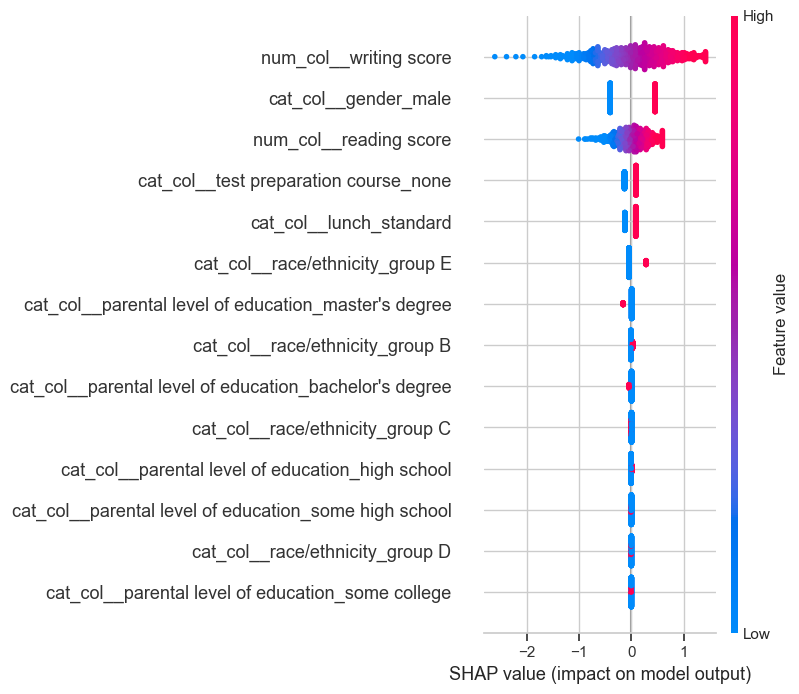

In [57]:
import shap

# --- Create SHAP Explainer ---
# Linear models work well with KernelExplainer or LinearExplainer
explainer = shap.LinearExplainer(linear_regression_model, X_train_encoded_df, feature_perturbation="interventional")

# --- Compute SHAP values ---
shap_values = explainer.shap_values(X_train_encoded_df)


# ---  Beeswarm Plot (Detailed feature effects) ---
plt.figure(figsize=(12,6))
shap.summary_plot(shap_values, X_train_encoded_df, plot_type="dot", max_display=15)
plt.show()


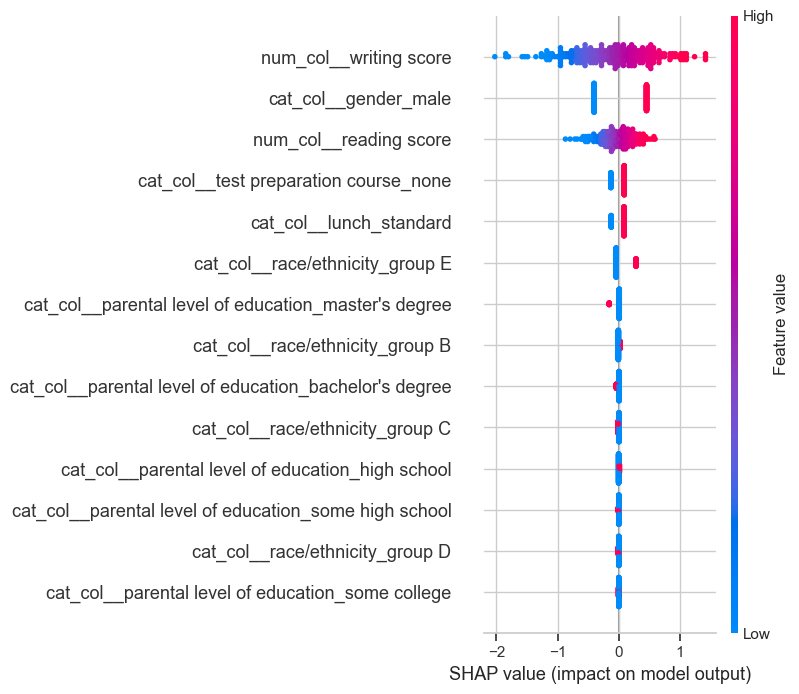

In [58]:
# --- Create LinearExplainer for test set (uses the training data as background) ---
explainer_test = shap.LinearExplainer(linear_regression_model, X_train_encoded_df, feature_perturbation="interventional")

# ---  Compute SHAP values for test set ---
shap_values_test = explainer_test.shap_values(X_test_encoded_df)

# ---  Beeswarm Plot (Feature effects on test predictions) ---
plt.figure(figsize=(12,6))
shap.summary_plot(shap_values_test, X_test_encoded_df, plot_type="dot", max_display=15)
plt.show()


# --- Force plot for a single prediction (optional, interactive) ---
shap.initjs()
shap.force_plot(explainer_test.expected_value, shap_values_test[0,:], X_test_encoded_df.iloc[0,:])


### SHAP Explanation of a Single Prediction

The SHAP (SHapley Additive exPlanations) waterfall plot above explains how each feature contributed to the model's prediction for a single student.

- **Base Value**: The gray vertical line at `-0.02903` represents the average model output across all students. This is the starting point for the prediction.

- **Feature Contributions**: Each colored block shows how a specific feature pushes the prediction away from the base value:
  - **Pink/Red Blocks** (`higher`): Features that increase the predicted value.
  - **Blue Blocks** (`lower`): Features that decrease the predicted value.

- **Interpretation of Features**:
  - `writing score = 69` → increases the prediction significantly.
  - `lunch_standard = 1` → increases the prediction.
  - `test preparation course_none = 1` → increases the prediction.
  - `reading score = 75` → further increases the prediction.
  - `gender_male = 1` → increases the prediction.
  - `race/ethnicity_group E = 0` → decreases the prediction slightly.

- **Final Prediction**: The predicted value of `0.71` is obtained by starting from the **base value** and adding/subtracting the contributions of each feature.  

**Summary**: SHAP provides a transparent way to see how each feature individually affects the model output. Positive values push the prediction higher, negative values push it lower, and the sum of all contributions plus the base value equals the final predicted value.
